Test of xugrid for vector data reading and translation to UGRID

Issue : DEI-17 HydroMT_habitat: rasters to (UGRID) NetCDF


*User story:*

As a user, I want to be able to combine my data in a raster format (geopackage, geodatabase, ASCII raster or GeoTIFF) to the UGRID NetCDF format so that I can use it for calculations with D-EcoImpact.


*Acceptance criteria:*

 - A GPK containing a raster can be translated to the NetCDF format fitting with the D-EI accepted convention, and exported as such.

 - A GDB containing a raster can be translated to the NetCDF format fitting with the D-EI accepted convention, and exported as such.

 - A ASCII raster  can be translated to the NETCDF format fitting with the D-EI accepted convention, and exported as such

 - A GeoTIFF can be translated to the NETCDF format fitting with the D-EI accepted convention, and exported as such.



Specific use case:

*Description:*
The objective is to load a raster data in UGRID so that it can be used for ecological calculations. 

*Acceptance criteria:*
- These rasters have been converted to the UGRID format, so that it may be used soley or in combination with other variables in ecological calculations with D-EcoImpact.
- This UGRID format raster data can be exported to NetCDF file.

This is a trial to test if XUGRID can load a vector to a UGRID structured NetCDF format.

In [1]:
#Libraries for plotting raw raster data
import rasterio
import rioxarray

import xarray as xr
import xugrid as xu
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import netCDF4 as nc

# %%
print(xu.__version__)

IMOD_ugrid_path1 = r"p:\11208420-habitat-kernel-dev\development_cases\JoeriVanEngelen_IMOD_model_20230223\ugrid_dommel_monthly.nc"


0.3.0


In [2]:
#read Netcdf
ds_in = IMOD_ugrid_path1
ds_out = r'd:\_checkouts\HabitatGit\test\data\test_ugrid_dommel_monthly.nc'

#add metadata
with nc.Dataset(ds_in) as src, nc.Dataset(ds_out, "w") as dst:
    # copy global attributes all at once via dictionary
    dst.setncatts(src.__dict__)
    # copy dimensions
    for name, dimension in src.dimensions.items():
        if(name == "face"):
            dst.createDimension(
                "mesh2d_nFaces", (len(dimension) if not dimension.isunlimited() else None))
        elif(name == "node"):
            dst.createDimension(
                "mesh2d_nNodes", (len(dimension) if not dimension.isunlimited() else None))
        elif(name == "nMax_face"):
            dst.createDimension(
                "mesh2d_nMax_face_nodes", (len(dimension) if not dimension.isunlimited() else None))    
        else:
            dst.createDimension(
                name, (len(dimension) if not dimension.isunlimited() else None))
        
        #midpoint between to edge nodes. Search node x position based on 
        # mesh2d_edge_nodes [0,1] and retrieve x coord from mesh2d_node_x (mesh2d_nEdges=variable)
        #dst.createDimension( "mesh2d_edge_x")
        #midpoint between to edge nodes. Search node y position based on 
        # mesh2d_edge_nodes [0,1] and retrieve y coord from mesh2d_node_x (mesh2d_nEdges=variable)
        #dst.createDimension( "mesh2d_edge_y")
        #midpoint of face. Search node x position based on 
        # mesh2d_face_nodes [0,1,2,3] and retrieve x coord from mesh2d_node_x.
        # Average all.(mesh2d_nFaces=variable)
        #dst.createDimension( "mesh2d_face_x")
        #midpoint of face. Search node y position based on 
        # mesh2d_face_nodes [0,1,2,3] and retrieve y coord from mesh2d_node_y.
        # Average all.(mesh2d_nFaces=variable)
        #dst.createDimension( "mesh2d_face_y")
        #coords of face nodes. Search node X position based on 
        # mesh2d_face_nodes [0,1,2,3] and retrieve all x coord from mesh2d_node_x.
        # Add them to a frame [0,1,2,3].(mesh2d_nFaces=variable, mesh2d_nMax_face_nodes=4)
        #dst.createDimension( "mesh2d_face_x_bnd")
        #coords of face nodes. Search node Y position based on 
        # mesh2d_face_nodes [0,1,2,3] and retrieve all Y coord from mesh2d_node_y.
        # Add them to a frame [0,1,2,3]. (mesh2d_nFaces=variable, mesh2d_nMax_face_nodes=4)
        #dst.createDimension( "mesh2d_face_y_bnd")
        
    # copy all file data except for the excluded
    for name, variable in src.variables.items():
        print(name)
        if(len(variable.dimensions) > 0):
            if("face" in variable.dimensions):
                new_dimensions = [tuple(s if s != "face" else "mesh2d_nFaces" for s in variable.dimensions)][0]
                
            elif("node" in variable.dimensions):
                new_dimensions = [tuple(s if s != "node" else "mesh2d_nNodes" for s in variable.dimensions)][0]
            
            elif("nMax_face" in variable.dimensions):
                new_dimensions = [tuple(s if s != "nMax_face" else "mesh2d_nMax_face_nodes" for s in variable.dimensions)][0]
            
            else:
                new_dimensions = variable.dimensions
        else:
            new_dimensions = variable.dimensions
        
        if name in ["face_x", "face_y", "node_x", "node_y", "face_nodes", "edge_nodes"]:
        #if name in ["face_x", "face_y", "node_x", "node_y"]:
            name_new = "mesh2d_" + name
            x = dst.createVariable(name_new, variable.datatype, new_dimensions)
        else:
            name_new = name
            x = dst.createVariable(name, variable.datatype, new_dimensions)
            
         #add variable attributes that were missing.
        temp_dict = src[name].__dict__
        if name_new == "mesh2d":

            temp_dict["node_coordinates"] = 'mesh2d_node_x mesh2d_node_y'
            temp_dict["face_node_connectivity"] = 'mesh2d_face_nodes'
            #mesh_dict = src[name].__dict__
            temp_dict = {k: temp_dict[k] for k in set(list(temp_dict.keys())) - set(["coordinates","edge_node_connectivity"])}
            print(temp_dict)

        elif name_new == "meshed_face_nodes":
        
            temp_dict["coordinates"] = 'mesh2d_face_x mesh2d_face_y'
            
        elif name_new in ["mesh2d_face_x", "mesh2d_node_x"]:
            
            temp_dict["standard_name"] = 'projection_x_coordinate'
            
        elif name_new in ["mesh2d_face_y", "mesh2d_node_y"]:
            
            temp_dict["standard_name"] = 'projection_y_coordinate'
            
        else:
            # copy variable attributes all at once via dictionary
            temp_dict = src[name].__dict__
        dst[name_new].setncatts(temp_dict)
        
        #add variable attributes that were missing.
        if name_new not in ["mesh2d_edge_nodes","mesh2d_face_nodes","mesh2d_face_x","mesh2_face_y","mesh2d", "mesh2d_node_x",\
                        "mesh2d_node_y","time", "mesh2d_edge_faces","mesh2d_edge_nodes","mesh2d_edge_type","mesh2d_edge_x",\
                        "mesh2d_edge_y", "mesh2d_face_nodes", "mesh2d_face_x","mesh2d_face_x_bnd",\
                        "mesh2d_face_y","mesh2d_face_y_bnd"]:
            dst[name_new].mesh = "mesh2d"
            dst[name_new].location = "face"
            dst[name_new].grid_mapping = "projected_coordinate_system"
            dst[name_new].coordinates = "mesh2d_face_x mesh2d_face_y"

        
        #add the data
        dst[name_new][:] = src[name][:]


mesh2d
{'long_name': 'Topology data of 2D mesh', 'cf_role': 'mesh_topology', 'topology_dimension': 2, 'face_node_connectivity': 'mesh2d_face_nodes', 'node_coordinates': 'mesh2d_node_x mesh2d_node_y'}
face_nodes
top_layer_1
top_layer_2
top_layer_3
top_layer_4
top_layer_5
top_layer_6
top_layer_7
top_layer_8
top_layer_9
top_layer_10
top_layer_11
top_layer_12
top_layer_13
top_layer_14
top_layer_15
bottom_layer_1
bottom_layer_2
bottom_layer_3
bottom_layer_4
bottom_layer_5
bottom_layer_6
bottom_layer_7
bottom_layer_8
bottom_layer_9
bottom_layer_10
bottom_layer_11
bottom_layer_12
bottom_layer_13
bottom_layer_14
bottom_layer_15
thickness_layer_1
thickness_layer_2
thickness_layer_3
thickness_layer_4
thickness_layer_5
thickness_layer_6
thickness_layer_7
thickness_layer_8
thickness_layer_9
thickness_layer_10
thickness_layer_11
thickness_layer_12
thickness_layer_13
thickness_layer_14
thickness_layer_15
lay_id_layer_1
lay_id_layer_2
lay_id_layer_3
lay_id_layer_4
lay_id_layer_5
lay_id_layer_6
lay_id

In [3]:
#Open this with XUGRID
uda = xu.open_dataset(ds_out)

In [8]:
#explore the data file
uda

<xarray.Dataset>
Dimensions:             (mesh2d_nFaces: 105859, time: 120, mesh2d_nNodes: 53080)
Coordinates:
    mesh2d_face_x       (mesh2d_nFaces) float64 ...
    mesh2d_face_y       (mesh2d_nFaces) float64 ...
  * time                (time) datetime64[ns] 2009-01-31 ... 2018-12-31
  * mesh2d_nFaces       (mesh2d_nFaces) int64 0 1 2 3 ... 105856 105857 105858
  * mesh2d_nNodes       (mesh2d_nNodes) int64 0 1 2 3 ... 53077 53078 53079
Data variables: (12/77)
    top_layer_1         (mesh2d_nFaces) float32 ...
    top_layer_2         (mesh2d_nFaces) float32 ...
    top_layer_3         (mesh2d_nFaces) float32 ...
    top_layer_4         (mesh2d_nFaces) float32 ...
    top_layer_5         (mesh2d_nFaces) float32 ...
    top_layer_6         (mesh2d_nFaces) float32 ...
    ...                  ...
    head_layer_12       (time, mesh2d_nFaces) float32 ...
    head_layer_13       (time, mesh2d_nFaces) float32 ...
    head_layer_14       (time, mesh2d_nFaces) float32 ...
    head_layer_15       (time, mesh2d_nFaces) float32 ...
    mesh2d_node_y       (mesh2d_nNodes) float64 3.824e+05 ... 3.822e+05
    mesh2d_node_x       (mesh2d_nNodes) float64 1.232e+05 ... 1.242e+05
Attributes:
    Conventions:  CF-1.8 UGRID-1.0

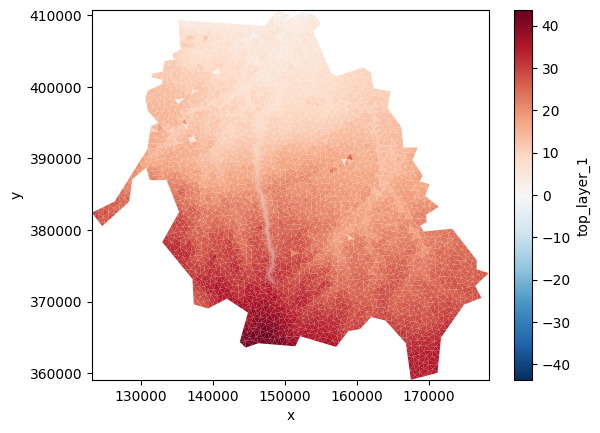

In [9]:
#plot the results
#uda["mesh2ds_nFaces"].ugrid.plot()
uda5["top_layer_1"].ugrid.plot()

In [42]:
#######################################################################################################################################
#AFter the D-EcoImpact run the result can be presented                                                                                #
# The result can not be showed yet in:                                                                                                #
#  - Quickplot : missing of edge_face_connectivity                                                                                    #
#  - QGIS : result is aggregated to yearly result, only one time axes can be shown and NetCDF should be split by time axes.
# XUGRID does already show the result (see below).
# Find Used Yaml file for D-EcoImpact run here :                                                                                                          #
# p:\11208420-habitat-kernel-dev\development_cases\JoeriVanEngelen_IMOD_model_20230223\D-EcoImpact calculation\test_IMOD_Dommel.yaml  #
#######################################################################################################################################

C:\Users\weeber\Miniconda3\envs\habitat\lib\site-packages\xugrid\ugrid\conventions.py:193: UserWarning: No standard_name of ('projection_x_coordinate', 'longitude', 'projection_y_coordinate', 'latitude') in ['node_x', 'node_y'].
Using node_x and node_y as projected x and y coordinates.
  warnings.warn(


Show original data (groundwaterhead : head_layer_1)


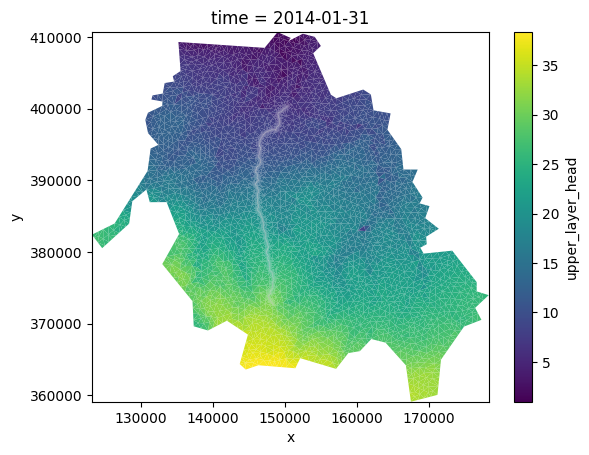

In [27]:
#Open result with XUGRID
ds_res = r"p:\11208420-habitat-kernel-dev\development_cases\JoeriVanEngelen_IMOD_model_20230223\D-EcoImpact calculation\data_out\results_dommel_IMOD.nc"
uda_res = xu.open_dataset(ds_res)

#Note that this test case of IMOD-MODFLOW results postprocessed with D-EcoImpact
# for ecological relevance is very simplistic. In reality a one of groundwater level lower or higher
# than preference won't lead to direct unsuitability. This example is just to show the technical implementation. 

print("Show original data (groundwaterhead : head_layer_1)")
uda_res["upper_layer_head"].isel(time = 60).ugrid.plot() 


Show minimum groundwater level in year (layer 1)


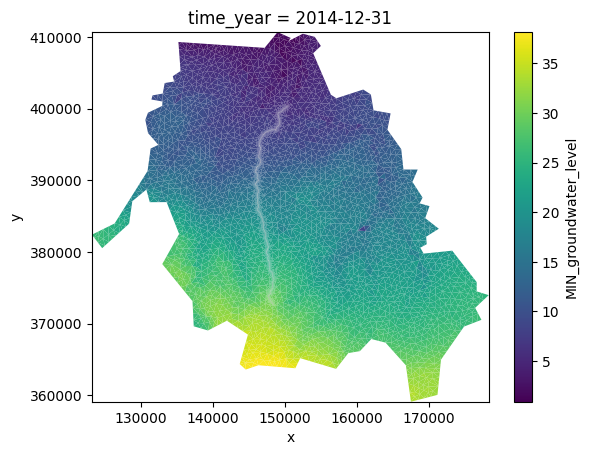

In [24]:
print("Show minimum groundwater level in year (layer 1)")
uda_res["MIN_groundwater_level"].isel(time_year = 5).ugrid.plot()

Show maximum groundwater level in year (layer 1)


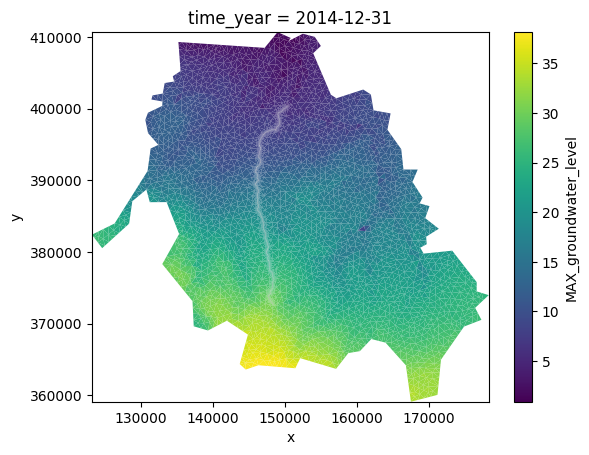

In [25]:
print("Show maximum groundwater level in year (layer 1)")
uda_res["MAX_groundwater_level"].isel(time_year = 5).ugrid.plot()

Show minimum groundwater level acceptable for Willow (0.2 m)
1 = suitable, 0 = unsuitable


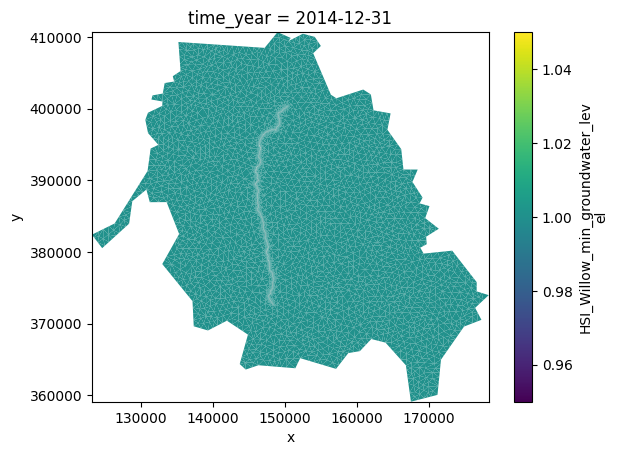

In [30]:
print("Show minimum groundwater level acceptable for Willow (0.2 m)")
print("1 = suitable, 0 = unsuitable")
uda_res["HSI_Willow_min_groundwater_level"].isel(time_year = 5).ugrid.plot()

Show maximum groundwater level acceptable for Willow (2.0 m)
1 = suitable, 0 = unsuitable


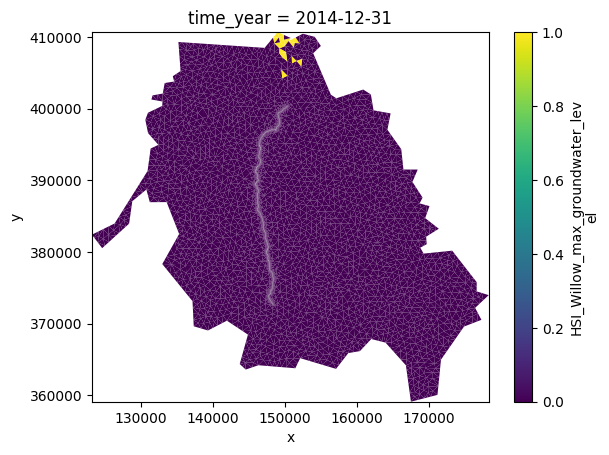

In [33]:
print("Show maximum groundwater level acceptable for Willow (2.0 m)")
print("1 = suitable, 0 = unsuitable")
uda_res["HSI_Willow_max_groundwater_level"].isel(time_year = 5).ugrid.plot()

Show combined (min-max) groundwater level suitability for Willow (0.2 - 2.0 m)


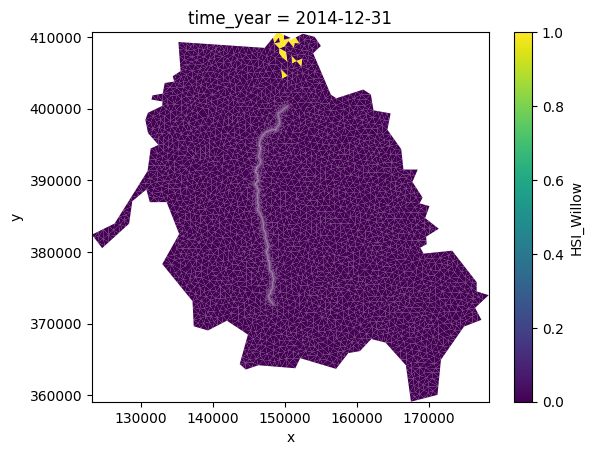

In [34]:
print("Show combined (min-max) groundwater level suitability for Willow (0.2 - 2.0 m)")
uda_res["HSI_Willow"].isel(time_year = 5).ugrid.plot()